In [1]:
import pandas as pd
import numpy as np

In [7]:
import json

train_data = pd.read_csv("../../results/data/ml/train_data.csv", index_col=0)
test_data = pd.read_csv("../../results/data/ml/test_data.csv", index_col=0)
X_train = train_data.drop("group", axis=1)
y_train = train_data["group"]
X_test = test_data.drop("group", axis=1)
y_test = test_data["group"]

feature_types = json.load(open("../../results/data/ml/feature_types.json"))
glycan_features = feature_types["glycan"]

In [3]:
X_train_glycan = X_train[glycan_features]

<ErrorbarContainer object of 3 artists>

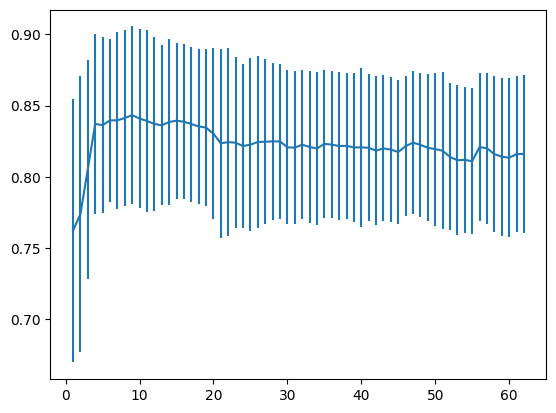

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from mrmr import mrmr_classif
import matplotlib.pyplot as plt

score_means = np.empty(len(glycan_features))
score_stds = np.empty(len(glycan_features))

ranks = mrmr_classif(X_train_glycan, y_train, K=len(glycan_features), show_progress=False)

for i in range(len(glycan_features)):
    selected_glycans = ranks[:i+1]
    X_train_subset = X_train[selected_glycans + ["AFP"]]
    pipe = make_pipeline(StandardScaler(), LogisticRegression())
    scores = cross_val_score(pipe, X_train_subset, y_train, cv=10, scoring="roc_auc")
    score_means[i] = scores.mean()
    score_stds[i] = scores.std()

plt.errorbar(range(1, len(glycan_features)+1), score_means, yerr=score_stds)

In [5]:
print(ranks[:4])

['H5N4F1', 'H4N4S1', 'H6N5F1S3', 'H3N4F1']


In [12]:
from sklearn.metrics import classification_report
from sklearn.calibration import CalibratedClassifierCV

final_features = ranks[:4] + ["AFP"]
lr = make_pipeline(StandardScaler(), LogisticRegression())
lr = CalibratedClassifierCV(lr, cv=10)
lr.fit(X_train[final_features], y_train)
y_pred = lr.predict(X_test[final_features])
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.81      0.83      0.82        71
        True       0.78      0.75      0.77        57

    accuracy                           0.80       128
   macro avg       0.80      0.79      0.79       128
weighted avg       0.80      0.80      0.80       128



In [14]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, lr.predict_proba(X_test[final_features])[:, 1])

0.8381517173214728

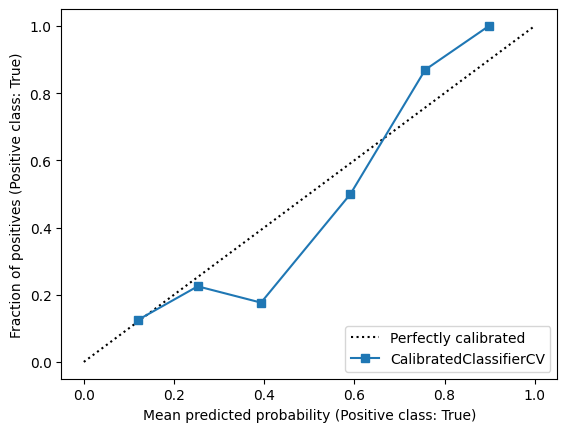

In [24]:
from sklearn.calibration import CalibrationDisplay

CalibrationDisplay.from_estimator(lr, X_test[final_features], y_test, n_bins=6)